In this nb, we compare the attributions values for the SN10 between the different tasks.

- We have the same positive dataset always, so the correlations are computed per positive part of dataset.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json

from scipy.stats import pearsonr, spearmanr

import torch
import torch.nn as nn
import torch.nn.functional as F

import logomaker

from NegativeClassOptimization import ml, visualisations
from NegativeClassOptimization import config, utils
from NegativeClassOptimization import preprocessing, datasets

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [2]:
from utils_07 import load_energy_contributions_from_task_nonlinear_version
from utils_07 import get_attr_from_records, get_onehotstack_from_records

In [3]:
task_types= [
    datasets.ClassificationTaskType.ONE_VS_NINE,
    datasets.ClassificationTaskType.HIGH_VS_95LOW,
    datasets.ClassificationTaskType.HIGH_VS_LOOSER,
]

loader = datasets.FrozenMiniAbsolutMLLoader(
    data_dir=Path("../data/Frozen_MiniAbsolut_ML/")
)

df_path = Path("07e_df_attr.csv")

if df_path.exists():
    df = pd.read_csv(df_path)
else:
    seed_id = 0
    split_id = 42
    attributor_name = "DeepLIFT_LOCAL_v2.0-2"
    dfs = []
    for ag in config.ANTIGENS:
        
        df = pd.DataFrame()
        for task_type in task_types:   
            task = datasets.ClassificationTask(
                task_type=task_type,
                ag_pos=ag,
                ag_neg="auto",
                seed_id=seed_id,
                split_id=split_id,
            )
            task = loader.load(task, attributions_toload="v2.0-2", attribution_records_toload="attribution_records_augmented.json")

            attr_stack = get_attr_from_records(
                task.attributions, attributor_name, (0, 1)  # type: ignore
            )  # Nx11x20 # type: ignore
            onehot_stack = get_onehotstack_from_records(
                task.attributions, (0, 1)  # type: ignore
            )  # Nx220 # type: ignore
            attr_aa = attr_stack[onehot_stack.reshape((-1, 11, 20)) == 1].reshape(
                -1, 11
            )  # Nx11

            
            df_i = pd.DataFrame.from_records(task.attributions)
            df_i["ag"] = ag
            col_aa = f"attr_aa_{task.task_type.to_str()}"
            col_logits = f"logits_{task.task_type.to_str()}"
            df_i[col_aa] = [arr for arr in attr_aa]
            df_i[col_logits] = df_i["logits"]

            df_i.query("y_true == 1", inplace=True)
            df_i = df_i[["slide", "ag", col_aa, col_logits]]

            if df.shape[0] == 0:
                df = df_i
            else:
                df = pd.merge(df, df_i, on=["slide", "ag"], how="inner")
        dfs.append(df)

    df = pd.concat(dfs, axis=0)
    df = df.reset_index(drop=True)
    df.to_csv(df_path, index=False)

In [4]:
def process_str_to_list_floats(s):
    vals = []
    for ch in s.replace("\n", "").strip("[] ").split(" "):
        if ch == "":
            continue
        vals.append(float(ch))
    assert len(vals) == 11
    return vals

df["attr_aa_high_vs_looser"] = df["attr_aa_high_vs_looser"].apply(process_str_to_list_floats) 
df["attr_aa_high_vs_95low"] = df["attr_aa_high_vs_95low"].apply(process_str_to_list_floats)
df["attr_aa_1v9"] = df["attr_aa_1v9"].apply(process_str_to_list_floats)

In [5]:
df["corr_attr_losser_95low"] = df.apply(lambda row: pearsonr(row["attr_aa_high_vs_looser"], row["attr_aa_high_vs_95low"])[0], axis=1)
df["corr_attr_9_looser"] = df.apply(lambda row: pearsonr(row["attr_aa_1v9"], row["attr_aa_high_vs_looser"])[0], axis=1) 
df["corr_attr_9_95low"] = df.apply(lambda row: pearsonr(row["attr_aa_1v9"], row["attr_aa_high_vs_95low"])[0], axis=1)

In [6]:
# Melt df across correlations
df_corr = df[["slide", "ag", "corr_attr_losser_95low", "corr_attr_9_looser", "corr_attr_9_95low"]]
df_corr = df_corr.melt(id_vars=["slide", "ag"], var_name="corr_type", value_name="corr_value")
df_corr

,slide,ag,corr_type,corr_value
0,CVRLGWLLHVF,3VRL,corr_attr_losser_95low,0.748119
1,CARIPLLLWLL,3VRL,corr_attr_losser_95low,0.471886
2,CARWGLLLYYF,3VRL,corr_attr_losser_95low,0.969266
3,CTRWGLLLYYF,3VRL,corr_attr_losser_95low,0.939957
4,CARIPLLLWYF,3VRL,corr_attr_losser_95low,0.856950
...,...,...,...,...
149995,NLLWLRLGYFD,1OB1,corr_attr_9_95low,-0.001743
149996,RLLWLRLGYFD,1OB1,corr_attr_9_95low,-0.084391
149997,SLLLLRLGYFD,1OB1,corr_attr_9_95low,0.132354
149998,ELVLLRLSWFA,1OB1,corr_attr_9_95low,0.614243


<AxesSubplot: xlabel='ag', ylabel='corr_value'>

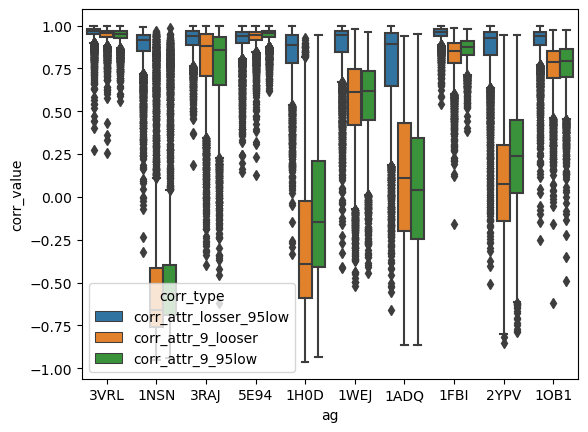

In [7]:
sns.boxplot(
    data=df_corr,
    x="ag",
    y="corr_value",
    hue="corr_type",
)

<AxesSubplot: xlabel='ag', ylabel='attr_value'>

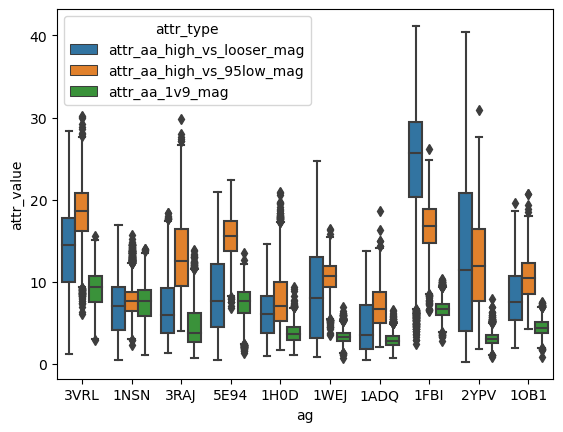

In [8]:
## Add the norm!
## Magnitude of attributions
df["attr_aa_high_vs_looser_mag"] = df["attr_aa_high_vs_looser"].apply(lambda x: np.linalg.norm(x, ord=2))
df["attr_aa_high_vs_95low_mag"] = df["attr_aa_high_vs_95low"].apply(lambda x: np.linalg.norm(x, ord=2))
df["attr_aa_1v9_mag"] = df["attr_aa_1v9"].apply(lambda x: np.linalg.norm(x, ord=2))

df_mag = df[["slide", "ag", "attr_aa_high_vs_looser_mag", "attr_aa_high_vs_95low_mag", "attr_aa_1v9_mag"]]
df_mag = df_mag.melt(id_vars=["slide", "ag"], var_name="attr_type", value_name="attr_value")
sns.boxplot(
    data=df_mag,
    hue="attr_type",
    y="attr_value",
    x="ag"
)

Model weights

In [9]:
task_types= [
    datasets.ClassificationTaskType.ONE_VS_NINE,
    datasets.ClassificationTaskType.HIGH_VS_95LOW,
    datasets.ClassificationTaskType.HIGH_VS_LOOSER,
]

loader = datasets.FrozenMiniAbsolutMLLoader(
    data_dir=Path("../data/Frozen_MiniAbsolut_ML/")
)


seed_id = 0
split_id = 42
records = []
for ag in config.ANTIGENS:
    
    df = pd.DataFrame()
    for task_type in task_types:   
        task = datasets.ClassificationTask(
            task_type=task_type,
            ag_pos=ag,
            ag_neg="auto",
            seed_id=seed_id,
            split_id=split_id,
        )
        
        task = loader.load(task, attributions_toload="v2.0-2", load_model=True)
        # Add model complexity
        L1_w = task.model.module.linear_1.weight
        L2_w = task.model.module.linear_2.weight
        L1_norm = L1_w.norm()
        L2_norm = L2_w.norm()
        records.append({
            "ag": ag,
            "task_type": task_type.to_str(),
            "L1_norm": L1_norm,
            "L2_norm": L2_norm,
            "SN10_norm": L1_norm + L2_norm,
        })

In [20]:
df_norms = pd.DataFrame.from_records(records)
df_norms["SN10_norm"] = df_norms["SN10_norm"].apply(lambda x: x.item())
df_norms["L1_norm"] = df_norms["L1_norm"].apply(lambda x: x.item())
df_norms["L2_norm"] = df_norms["L2_norm"].apply(lambda x: x.item())
df_norms.head()

,ag,task_type,L1_norm,L2_norm,SN10_norm
0,3VRL,1v9,27.650110,7.238309,34.888420
1,3VRL,high_vs_95low,24.919481,8.731784,33.651264
2,3VRL,high_vs_looser,32.371429,9.706873,42.078300
3,1NSN,1v9,29.746561,8.653611,38.400173
4,1NSN,high_vs_95low,26.225658,6.482751,32.708408


<AxesSubplot: xlabel='L1_norm', ylabel='L2_norm'>

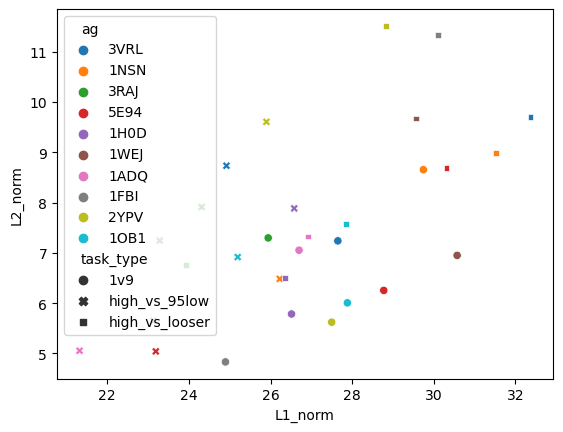

In [21]:
sns.scatterplot(
    data=df_norms,
    x="L1_norm",
    y="L2_norm",
    hue="ag",
    style="task_type",
)

<AxesSubplot: xlabel='ag', ylabel='SN10_norm'>

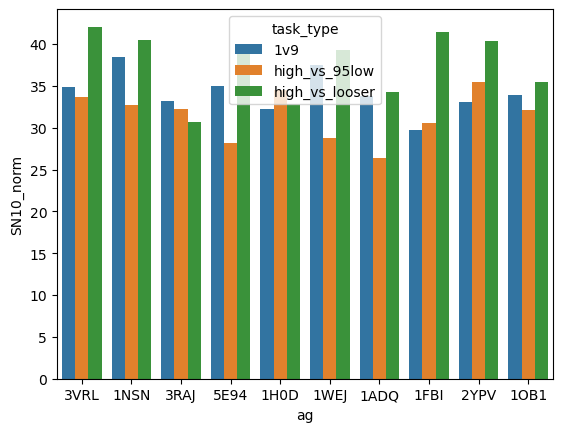

In [19]:
sns.barplot(
    data=df_norms,
    hue="task_type",
    y="SN10_norm",
    x="ag"
)

<AxesSubplot: xlabel='ag', ylabel='L1_norm'>

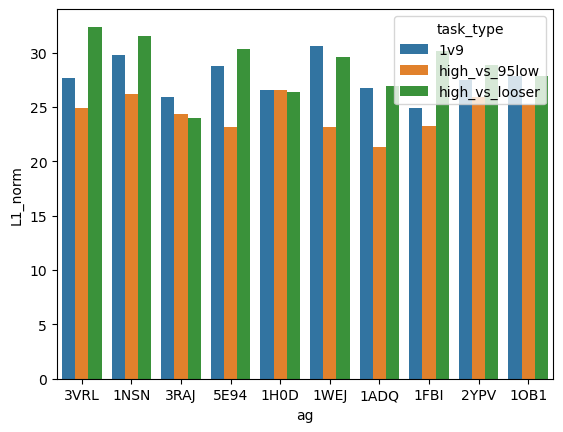

In [23]:
sns.barplot(
    data=df_norms,
    hue="task_type",
    y="L1_norm",
    x="ag"
)

<AxesSubplot: xlabel='ag', ylabel='L2_norm'>

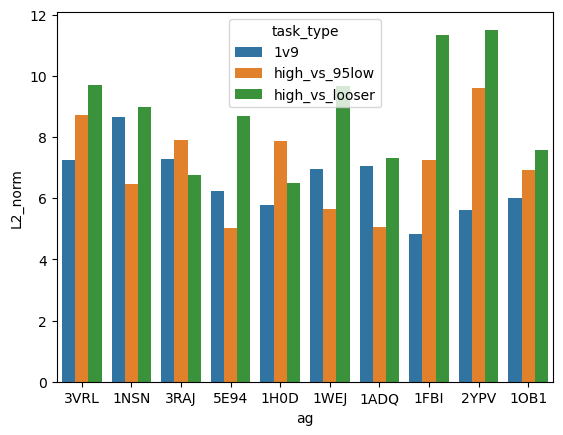

In [22]:
sns.barplot(
    data=df_norms,
    hue="task_type",
    y="L2_norm",
    x="ag"
)